In [ ]:
!rm -rf

In [1]:
%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
from PIL import Image
import random
import ultralytics 
ultralytics.checks()
import torch
# Load RetinaNet model
from torchvision.models.detection import retinanet_resnet50_fpn

Ultralytics 8.3.53 🚀 Python-3.8.19 torch-2.2.2 CUDA:0 (NVIDIA GeForce RTX 3090, 24245MiB)
Setup complete ✅ (24 CPUs, 62.7 GB RAM, 142.7/150.9 GB disk)


In [3]:
img_path   = 'PlantVillage_for_object_detection/Dataset/images'
label_path = 'PlantVillage_for_object_detection/Dataset/labels'

In [4]:
ipaths=[]
tpaths=[]
types=[]
for dirname, _, filenames in os.walk(img_path):
    for filename in filenames:
        ipaths+=[os.path.join(dirname, filename)]
        types+=[filename.split('.')[-1]]


for dirname, _, filenames in os.walk(label_path):
    for filename in filenames:
        tpaths+=[os.path.join(dirname, filename)]   

ipaths=sorted(ipaths)
tpaths=sorted(tpaths)

In [5]:
paths=[]
for ip,tp in zip(ipaths,tpaths):
    paths.append([ip,tp])
random.shuffle(paths)


ipaths=[]
tpaths=[]
for p in paths[:1000]:
    ipaths.append(p[0])
    tpaths.append(p[1])

In [6]:
boxdata=[]
boxfile=[]
for i in range(len(tpaths)):
    boxdata+=[np.loadtxt(tpaths[i])]     
    boxfile+=[ipaths[i].split('/')[-1]]
print(boxdata[0])

[         28     0.50586     0.49609     0.88672     0.99219]


In [7]:
boxdata[i]

array([         35,     0.45312,     0.51758,     0.74219,     0.91797])

In [8]:
All_boxes = pd.DataFrame(columns=['Class_no', 'x_coordinate','y_coordinate','width', 'height', 'name'])

for i in range(len(boxdata)):
    if type(boxdata[i][0])==np.float64:
        add=pd.DataFrame([boxdata[i]], columns=['Class_no', 'x_coordinate','y_coordinate','width', 'height'])
        add['name']=boxfile[i]
        All_boxes=pd.concat([All_boxes,add])
    else:
        add=pd.DataFrame(boxdata[i], columns=['Class_no', 'x_coordinate','y_coordinate','width', 'height'])
        add['name']=boxfile[i]
        All_boxes=pd.concat([All_boxes,add])       

All_boxes = All_boxes.reset_index(drop=True)
All_boxes.iloc[:,0] = All_boxes.iloc[:,0].astype(int)
display(All_boxes)

,Class_no,x_coordinate,y_coordinate,width,height,name
0,28.0,0.505859,0.496094,0.886719,0.992188,TMBS_image (100).jpg
1,15.0,0.496094,0.496094,0.828125,0.968750,ORHL_image (739).jpg
2,15.0,0.503906,0.501953,0.898438,0.980469,ORHL_image (4258).jpg
3,31.0,0.498047,0.500000,0.761719,0.992188,TMLM_image (433).jpg
4,25.0,0.498047,0.500000,0.996094,1.000000,SQPM_image (837).jpg
...,...,...,...,...,...,...
998,28.0,0.511719,0.500000,0.695312,0.976562,TMBS_image (1046).jpg
999,35.0,0.492188,0.486328,0.757812,0.894531,TMYC_image (4471).jpg
1000,16.0,0.515625,0.505859,0.765625,0.988281,PCBS_image (1784).jpg
1001,26.0,0.498047,0.500000,0.941406,1.000000,STLS_image (615).jpg


In [9]:
def draw_box(n0):
    
    ipath=ipaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1] 
    
    if All_boxes[All_boxes['name']==file] is not None:
        box=All_boxes[All_boxes['name']==file]
        box=box.reset_index(drop=True)
        
        for i in range(len(box)):
            label, x, y, w, h = int(box.iloc[i,0]), box.iloc[i,1], box.iloc[i,2], box.iloc[i,3], box.iloc[i,4]
            x1, y1, x2, y2=((x-w/2)*W).astype(int), ((y-h/2)*H).astype(int), ((x+w/2)*W).astype(int), ((y+h/2)*H).astype(int)
            
            cv2.rectangle(image,(x1,y1),(x2,y2),(0,0,255),2) #green
            cv2.putText(image, f'{label}', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)   

    plt.imshow(image)
    plt.show()
    
    return image

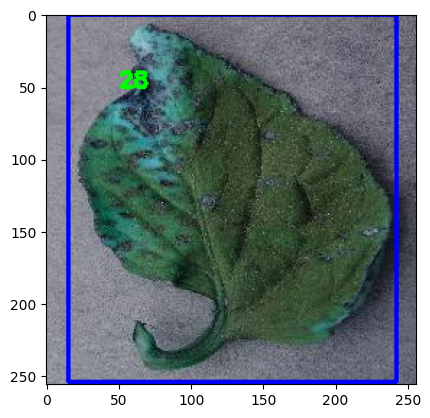

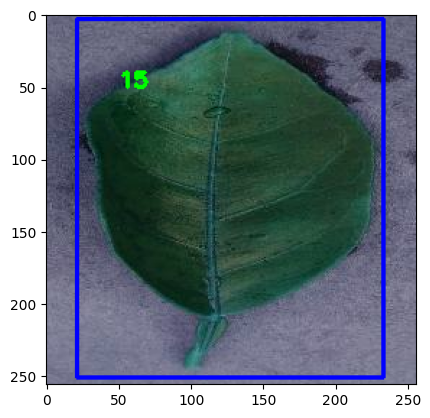

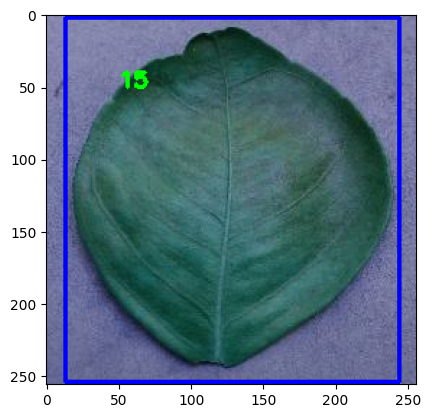

In [10]:
for i in range(3):
    draw_box(i)

In [11]:
def create_animation(ims):    
    fig=plt.figure(figsize=(10,6))
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    plt.show()    

In [12]:
os.makedirs('datasets', exist_ok=True)
os.makedirs('datasets/train', exist_ok=True)
os.makedirs('datasets/valid', exist_ok=True)
os.makedirs('datasets/test', exist_ok=True)

for i in range(len(ipaths)):
    ipath=ipaths[i]
    ifile=ipath.split('/')[-1]
    tpath=tpaths[i]
    tfile=tpath.split('/')[-1]

    if i%3==0:
        copyfile(ipath, f'datasets/train/{ifile}')
        copyfile(tpath, f'datasets/train/{tfile}')
    elif i%3==1:
        copyfile(ipath, f'datasets/valid/{ifile}')
        copyfile(tpath, f'datasets/valid/{tfile}')
    else:
        copyfile(ipath, f'datasets/test/{ifile}')
        #copyfile(tpath, f'datasets/test/{tfile}')  

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class CustomRetninaDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms or T.ToTensor()
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png') ]

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, os.path.splitext(self.images[idx])[0]+'.txt')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = [], []

        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_id, center_x, center_y, width, height = map(float, line.strip().split())
                xmin = center_x - (width / 2)
                ymin = center_y - (height / 2)
                xmax = center_x + (width / 2)
                ymax = center_y + (height / 2)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(class_id))
        target = {
            'boxes' : torch.tensor(boxes, dtype = torch.float32),
            'labels': torch.tensor(labels, dtype = torch.int64)
        }
        return self.transforms(img), target
    
    def __len__(self):
        return len(self.images)


In [ ]:
train = '/media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/train'
val = '/media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/valid'
test= '/media/thor/hdd4/NBSoft/nadim/Ahsan_sir_task/detection/datasets/test'

train_dataset = CustomRetninaDataset(train, train)
val_dataset = CustomRetninaDataset(val, val)
test_dataset = CustomRetninaDataset(test, test)

train_loader = DataLoader(train_dataset, batch_size= 24, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader   = DataLoader(val_dataset, batch_size= 24, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader   = DataLoader(test_dataset, batch_size= 24, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
len(train_loader)

213

In [ ]:
model = retinanet_resnet50_fpn(pretrained=True)
model.train()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
epoch = 20

for  epoch in range(epoch):
    for imgs, targets in train_loader:
        ims = list(img.to(device) for img in imgs)
        targets = [ { k: v.to(device) for k,v in t.items() } for t in targets]

        loss_dict = model(ims, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    torch.save(model.state_dict(), 'retina_model_save/model'+str(epoch)+'.pth')
    print("epoch Done", epoch)
print(f"Epoch {epoch} Loss: {losses.item():.4f}")


In [ ]:
model = retinanet_resnet50_fpn(pretrained=True)
model.load_state_dict(torch.load('retina_model_save/model'+str(epoch)+'.pth',
                       map_location=device))
model.to(device)
model.eval()







test_image = Image.open(' ').convert('RGB')
test_label= np.loadtxt(' ')
transform = T.ToTensor()
img_tensor = transform(test_image).unsqueeze(0).to(device)
image_np = np.array(test_image)  

with torch.no_grad():
    output = model(img_tensor.to(device))[0]




for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
    if score > 0.32:
        print(f"Detected class {label} at {box.tolist()} with confidence {score:.2f}")
        # print(output['boxes'])
        xmin, ymin, xmax, ymax = box
        
            
        cv2.rectangle(image_np, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 20)
        cv2.putText(image_np, f'{label.item()}', (int(xmin)+200, int(ymin) +200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 5)

plt.imshow(image_np)
plt.axis('off')
plt.show()